# Knowledge Distillation

This notebook is an experimental part of the homework and not worth points. It is not guaranteed to work correctly.

A trend in Natural Language Processing is to pretrain large models that can then be fine-tuned for specific problems. However the state-of-the-art models can be quite large: the "base" BERT model has 110M parameters and the "large" BERT model has 350M parameters! In many applications, such as client-side mobile apps, we do not have the compute to run the BERT model even in an evaluation setting.

Here we look at a method for reducing model size, called Knowledge Distillation. Specifically, we will follow the paper **[TinyBERT: Distilling BERT for Natural Language Understanding](https://arxiv.org/abs/1909.10351)**.
In this assignment you will:
- Use an off-the-shelf API to replicate a paper method
- Implement loss functions for KD as specified by the paper

## Before You Get Started

Read the paper. Also, the API we will be using is the Transformers API released by HuggingFace. It may be helpful to look at the **[documentation](https://huggingface.co/transformers/)**.

# Library Imports

In [1]:
#%%capture
#block the output to keep not pollute the notebook
!pip install transformers
!pip install datasets
# !conda install -c huggingface -c conda-forge transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00


In [2]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    DRIVE=True
    drive.mount('/content/drive')
    root_folder = "/content/drive/My Drive/cs182_hw3_anton/"
    public_folder = "/content/drive/My Drive/cs182_hw3_public/"
    dataset_folder = "/content/drive/My Drive/cs182_hw3_public/dataset/"
    print('Running on Colab')
else:
    DRIVE=False
    root_folder = ""
    public_folder = ""
    dataset_folder = "dataset/"
    print('Running on localhost')

Mounted at /content/drive
Running on Colab


In [3]:
import os
import sys
sys.path.append(root_folder)
import json
from utils import validate_to_array, model_out_to_list
import torch
from torch.nn import functional as F
from torch import nn
from torch import optim
import numpy as np
import math

from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig, BertForPreTraining

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = th.device("cpu")
print(device)

%load_ext autoreload
%autoreload 2

cuda


# BERT Architecture

First load the BERT base model and take a look at the architecture. Don't mind the warnings for now. Based on the nn.Module names, what major component from the Transformer architecture in "Attention is All You Need" is substantially smaller in the BERT model? What is the purpose of the component?

**Answer**: BERT doesn't really have a decoder component, whereas the original Transformer architecture had one encoder stack and a parallel decoder stack which used masked self-attention. Here, BERT doesn't use masked self-attention. Instead, it uses a masked language model (here abbreviated MLM) pre-training objective, which means that some of the tokens in the input sequence are masked out, and the model is trained to learn what the masked tokens are.

In other words, it has half the components. That said, it uses N=12 stacks, whereas Transformer used N=6, so it kinda comes out like a net wash parameter-wise...

In [4]:
%%capture
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)
teacher_model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
print(teacher_model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

# KD Losses

First, we need to access the intermediate layer outputs of the model. Read section 3 of the paper and take a look at the documentation for __[the forward function](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel.forward)__, or look at the docstring below. Fill in the kwargs to retrieve the necessary outputs from the model. Note that returning the embedding is not an option, you can retrieve the embeddings via a method attribute of BERT, `get_input_embeddings(self)`. Consider what an embedding is; why wouldn't we need to return an embedding for every sample in a batch?

In [5]:
# ok so our KD loss is going to include Transformer-layer distillation, embedding-layer distillation, and prediction-layer distillation.
# for prediction layer we'll obviously get the outputs to compare
# for embedding layer, ... unclear.
# that leaves transformer-layer, which has losses for multi-headed attention matrices A_i, and hidden states H. those are the ones we need to get here.

# looking at the documentation, the relevant kwargs are pretty obvious. implemented below.

forward_kwargs = dict(
    output_attentions=True,      # for L_attn
    output_hidden_states=True,   # for L_hidn
    return_dict=True,            # provided by template
)

Implement to EmbeddingLayerLoss, AttentionLayerLoss, HiddenLayerLoss, PredictionLoss, and KnowledgeDistillationLoss as specified in section 3 of the paper. The output of BERT will be a dictionary, look at 'return' in the documentation or the docstring for the relevant keys in the return dictionary. We will add the embedding in under 'embeddings'

## (1) Implementing the Attention Layer Loss

This part is located in AttentionLayerLoss in kd_loss.py. You must implement the call function of the class. You will need to implement the formula (7) in section 3 of __[TinyBERT](https://arxiv.org/pdf/1909.10351.pdf)__. Note that the actual implemetation compares raw output from attention. The transformers API returns the softmax output.

In [7]:
from kd_loss import AttentionLayerLoss
num_channels = 10
batch_size = 2

with open(public_folder+"kd_checks/kd_attention_loss.json",'r') as f:
  io = json.load(f)
  teacher_attn = torch.tensor(io['teacher_attention'])
  student_attn = torch.tensor(io['student_attention'])
  expected_output = torch.tensor(io['expected_output'])

attn_loss = AttentionLayerLoss()
output = attn_loss(teacher_attn, student_attn)

print("Total error on the output:",torch.sum(torch.abs(expected_output-output)).item(), "(should be 0.0 or close to 0.0)")

Total error on the output: 0.0 (should be 0.0 or close to 0.0)


## (2) Implementing the Hidden Layer Loss

This part is located in HiddenLayerLoss in kd_loss.py. You must implement the call function of the class. You will need to implement the formula (8) in section 3 of __[TinyBERT](https://arxiv.org/pdf/1909.10351.pdf)__

In [13]:
public_folder+"kd_checks/"

'/content/drive/My Drive/cs182_hw3_public/kd_checks/'

In [15]:
!ls '/content/drive/My Drive/cs182_hw3_public/kd_checks/'

kd_attention_loss.json	kd_embed_loss.zip    kd_loss	   kd_pred_loss
kd_embed_loss		kd_hidden_loss.json  kd_loss.json  kd_pred_loss.json
kd_embed_loss.json	kd_hidden_loss.zip   kd_loss.zip   kd_pred_loss.zip


In [16]:
from kd_loss import HiddenLayerLoss
teacher_hidden_dim = 50
student_hidden_dim = 10
batch_size = 2

with open(public_folder+"kd_checks/kd_hidden_loss.json",'r') as f:
  io = json.load(f)
  teacher_hddn = torch.tensor(io['teacher_hidden'])
  student_hddn = torch.tensor(io['student_hidden'])
  expected_output = torch.tensor(io['expected_output'])

hddn_loss = HiddenLayerLoss(teacher_hidden_dim,student_hidden_dim)
hddn_loss.load_state_dict(torch.load(public_folder+"kd_checks/kd_hidden_loss.zip"))
output = hddn_loss(teacher_hddn, student_hddn)

print("Total error on the output:",
      torch.sum(torch.abs(expected_output-output)).item(),
      "(should be 0.0 or close to 0.0)")

Total error on the output: 0.0 (should be 0.0 or close to 0.0)


## (3) Implementing the Embedding Layer Loss

This part is located in EmbedLayerLoss in kd_loss.py. You must implement the call function of the class. You will need to implement the formula (9) in section 3 of __[TinyBERT](https://arxiv.org/pdf/1909.10351.pdf)__

In [17]:
from kd_loss import EmbeddingLayerLoss
teacher_embed_dim = 50
student_embed_dim = 10
batch_size = 2

with open(public_folder+"kd_checks/kd_embed_loss.json",'r') as f:
  io = json.load(f)
  teacher_embd = torch.tensor(io['teacher_embed'])
  student_embd = torch.tensor(io['student_embed'])
  expected_output = torch.tensor(io['expected_output'])

embd_loss = EmbeddingLayerLoss(teacher_embed_dim,student_embed_dim)
embd_loss.load_state_dict(torch.load(public_folder+"kd_checks/kd_embed_loss"))
output = embd_loss(teacher_embd, student_embd)

print("Total error on the output:",
      torch.sum(torch.abs(expected_output-output)).item(),
      "(should be 0.0 or close to 0.0)")

Total error on the output: 0.0 (should be 0.0 or close to 0.0)


## (4) Implementing the Prediction Loss

This part is located in PredictionLoss in kd_loss.py. You must implement the call function of the class. You will need to implement the formula (10) in section 3 of __[TinyBERT](https://arxiv.org/pdf/1909.10351.pdf)__

In [18]:
from kd_loss import PredictionLoss
word_count = 10
batch_size = 2

with open(public_folder+"kd_checks/kd_pred_loss.json",'r') as f:
  io = json.load(f)
  teacher_pred = torch.tensor(io['teacher_pred'])
  student_pred = torch.tensor(io['student_pred'])
  expected_output = torch.tensor(io['expected_output'])

pred_loss = PredictionLoss()
output = pred_loss(teacher_pred, student_pred)

print("Total error on the output:",
      torch.sum(torch.abs(expected_output-output)).item(),
      "(should be 0.0 or close to 0.0)")

Total error on the output: 0.02235579490661621 (should be 0.0 or close to 0.0)


## (5) Implementing the Knowledge Distillation Loss

This part is located in KnowledgeDistillationLoss in kd_loss.py. You must implement the call function of the class. You will need to implement the formula (11) in section 3 of __[TinyBERT](https://arxiv.org/pdf/1909.10351.pdf)__

In [22]:
from kd_loss import KnowledgeDistillationLoss
num_channels = 12
teacher_hidden_dim = 60
student_hidden_dim = 15
teacher_embed_dim = 50
student_embed_dim = 10
word_count = 5
teacher_num_blocks = 6
student_num_blocks = 2
batch_size = 2
layer_mapping = range(2,6,3)

with open(public_folder+"kd_checks/kd_loss.json",'r') as f:
  io = json.load(f)
  teacher_out = io['teacher_out']
  student_out = io['student_out']
  teacher_out = dict(
      embeddings=torch.tensor(teacher_out['embeddings']),
      attentions=[torch.tensor(o) for o in teacher_out['attentions']],
      hidden_states=[torch.tensor(o) for o in teacher_out['hidden_states']],
      logits=torch.tensor(teacher_out['embeddings'])
  )
  student_out = dict(
      embeddings=torch.tensor(student_out['embeddings']),
      attentions=[torch.tensor(o) for o in student_out['attentions']],
      hidden_states=[torch.tensor(o) for o in student_out['hidden_states']],
      logits=torch.tensor(student_out['embeddings'])
  )
  expected_output = torch.tensor(io['expected_output'])

kd_loss = KnowledgeDistillationLoss(teacher_embed_dim,student_embed_dim,teacher_hidden_dim,student_hidden_dim,layer_mapping)
kd_loss.load_state_dict(torch.load(public_folder+"kd_checks/kd_loss"))
output = kd_loss(teacher_out, student_out)

print("Total error on the output:",
      torch.sum(torch.abs(expected_output-output)).item(),
      "(should be 0.0 or close to 0.0)")

Total error on the output: 0.4856206178665161 (should be 0.0 or close to 0.0)


# Experimental Setup

## General Distillation

### Data Loading

Below is the text parsing set up. We will be using the wikitext dataset as used in the paper. But since we are just demonstrating the method, we will use the small wikitext-2 dataset instead of the standard wikitext-103 set. Wikitext contains thousands of cleaned English Wikipedia articles separated by sentence. Since the order of sentences is left in tact, the dataset can be used to model long term dependencies between words.

In [6]:
%%capture
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

See that the data has been split into training, validation, and testing sets.

In [24]:
print(datasets)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


A sample of the dataset:

In [25]:
datasets['train'][5]

{'text': " It met with positive sales in Japan , and was praised by both Japanese and western critics . After release , it received downloadable content , along with an expanded edition in November of that year . It was also adapted into manga and an original video animation series . Due to low sales of Valkyria Chronicles II , Valkyria Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 . Media.Vision would return to the franchise with the development of Valkyria : Azure Revolution for the PlayStation 4 . \n"}

In [27]:
print("".join(datasets['train'][:2]['text']))

 = Valkyria Chronicles III = 



The words must be parsed and hashed according to the vocabulary of our model. Instead of masking sentences to equal length, this time we will separate the contiguous text sequence into equal size blocks, possibly breaking up whole sentences.

In [7]:
%%capture
tokenized_datasets = datasets.map(lambda samples: tokenizer(samples['text']), batched=True, num_proc=4, remove_columns=["text"])

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


In [35]:
# look at a sample
print(datasets['train'][1])
print(tokenized_datasets['train'][1])

{'text': ' = Valkyria Chronicles III = \n'}
{'input_ids': [101, 1027, 11748, 4801, 4360, 11906, 3523, 1027, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [38]:
tokenizer.convert_ids_to_tokens(tokenized_datasets['train'][1]['input_ids'])

['[CLS]', '=', 'val', '##ky', '##ria', 'chronicles', 'iii', '=', '[SEP]']

In [8]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    # passing start=[] to sum() acts as concatenation
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder.
    # we could add padding if the model supported it instead of this drop
    # you can customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [9]:
%%capture

# in batches of the tokenized dataset (batchsize=1000), split the batches
# into blocks of size 128.

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
    load_from_cache_file=False
)

In [53]:
# before
print(f"before splitting into blocks: {tokenized_datasets['train'].num_rows} records")
print('1st record')
print(tokenizer.decode(tokenized_datasets['train'][1]['input_ids']))

# after
print(f"\nafter splitting into blocks: {lm_datasets['train'].num_rows} records")
print('0th record')
print(tokenizer.decode(lm_datasets["train"][0]["input_ids"]))


before splitting into blocks: 36718 records
1st record
[CLS] = valkyria chronicles iii = [SEP]

after splitting into blocks: 18549 records
0th record
[CLS] [SEP] [CLS] = valkyria chronicles iii = [SEP] [CLS] [SEP] [CLS] senjo no valkyria 3 : unrecorded chronicles ( japanese : 戦 場 のウァルキュリア3, lit. valkyria of the battlefield 3 ), commonly referred to as valkyria chronicles iii outside japan, is a tactical role @ - @ playing video game developed by sega and media. vision for the playstation portable. released in january 2011 in japan, it is the third game in the valkyria series. employing the same fusion of tactical and real @ - @ time gameplay as its predecessors, the story runs parallel to


In [54]:
lm_datasets["train"][1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

### Set Up Student Model

Fill in the dimensions of BERT and the student network as specified in section 4.2 of the paper

In [10]:
vocab_size = int(1e4)
teacher_hddn_dim = 768
student_hddn_dim = 312
teacher_num_hddn_layers = 12
student_num_hddn_layers =  4
teacher_num_attn_heads = 12
student_num_attn_heads = 12
teacher_ff_dim = 3072
student_ff_dim = 1200
teacher_embd_dim = teacher_hddn_dim
student_embd_dim = student_hddn_dim
layer_mapping = range(0,
                      teacher_num_attn_heads,
                      3)

student_config = BertConfig(
    hidden_size=student_hddn_dim,
    num_hidden_layers=student_num_hddn_layers,
    num_attention_heads=student_num_attn_heads,
    intermediate_size=student_ff_dim,
)

### Training

Train the student model using the Knowledge Distillation loss. This is the general training phase, where we are training over the Wikitext corpus. (Specific task fine-tuning will follow, for one of the NLP benchmark tests.)

In [11]:
from kd_loss import KnowledgeDistillationLoss

# from_pretrained loads the config and state of the model.
# this model https://huggingface.co/bert-base-uncased was pretrained
# on BookCorpus and English Wikipedia
teacher_model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)

# load_state_dict changes the loaded state of the model, here presumably for the finetuning
# on the Wikitext dataset that this notebook wanted me to use.
# incompatibility of versions, so I can't load it. skipping.
# teacher_model.load_state_dict(torch.load(public_folder+'bert_models/teacher_wikitext.pt'))
student_model = BertForMaskedLM(student_config).to(device)
criterion = KnowledgeDistillationLoss(teacher_embd_dim,
                                      student_embd_dim,
                                      teacher_hddn_dim,
                                      student_hddn_dim,
                                      layer_mapping).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
from tqdm.notebook import tqdm
import gc

gc.collect()

# from the BERT paper (Devlin et al):
# "We fine-tune for 3 epochs with a learning rate of 5e-5 and a batch size of 32."
lr = 5e-5
batch_size = 32
optimizer = optim.Adam(params=student_model.parameters(),
                       lr=lr,
                       weight_decay=0.01)

# TinyBERT paper uses 3 epochs for general distillation
epochs = 3

for epoch in range(epochs):
    t = tqdm(range(0, len(lm_datasets["train"]), batch_size))
    # shuffle the dataset each epoch so that the batches are different
    lm_datasets["train"].shuffle(load_from_cache_file=False)
    accuracies = []
    losses = []

    # for each batch
    for i in t:
        # get the data batch and push it to device
        data = lm_datasets["train"][i:i+batch_size]
        data = {k: torch.tensor(v).to(device) for k,v in data.items()}

        # pass the data through each model
        # forward_kwargs is what we defined at the very beginning
        # in order to output the hidden states and attention matrices
        teacher_out = teacher_model(**data,**forward_kwargs)
        student_out = student_model(**data,**forward_kwargs)

        # add the embedding to the output
        teacher_out['embeddings'] = teacher_model.get_input_embeddings().weight
        student_out['embeddings'] = student_model.get_input_embeddings().weight

        # calculate the KD loss
        loss = criterion(teacher_out,student_out,penalize_prediction=False)
        losses.append(loss.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate the accuracy for this batch
        accuracy = torch.eq(student_out['logits'].argmax(dim=2,keepdim=False).float(),data['labels']).float().mean()
        accuracies.append(accuracy.detach().cpu().numpy())

        # for the last 100 batches, get average loss and accuracy
        loss = np.round(np.mean(losses[-100:]),3)
        accuracy = np.round(np.mean(accuracies[-100:]),2)
        t.set_description("Epoch: "+str(epoch)+" Loss: "+str(loss))

    os.makedirs(root_folder+'bert_models',exist_ok=True)
    torch.save(student_model.state_dict(),root_folder+'bert_models/student_wikitext.pt')

  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/580 [00:00<?, ?it/s]

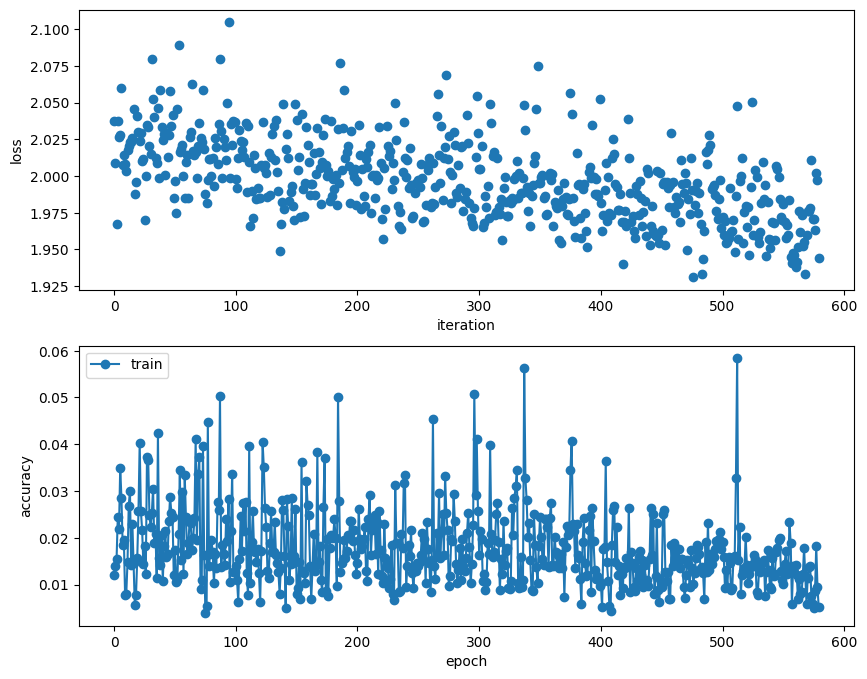

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.subplot(2, 1, 1)
plt.plot(losses, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(accuracies, '-o')
plt.legend(['train'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

We next train a control, which is just the same BERT shaped student model trained from scratch on general and task specific data.

In [63]:
control_model = BertForMaskedLM(student_config).to(device)
gc.collect()
control_model.train()

lr = 1e-4
optimizer = optim.Adam(params=control_model.parameters(),
                       lr=lr,
                       weight_decay=0.01)

batch_size = 10
epochs=1

for epoch in range(epochs):
    t = tqdm(range(0,len(lm_datasets["train"]),batch_size))
    lm_datasets["train"].shuffle()
    accuracies = []
    losses = []

    for i in t:
        data = lm_datasets["train"][i:i+batch_size]
        data = {k: torch.tensor(v).to(device) for k,v in data.items()}

        control_out = control_model(**data,**forward_kwargs)
        losses.append(control_out['loss'].detach().cpu().numpy())

        optimizer.zero_grad()
        control_out['loss'].backward()
        optimizer.step()

        accuracy = torch.eq(control_out['logits'].argmax(dim=2,keepdim=False).float(),data['labels']).float().mean()
        accuracies.append(accuracy.detach().cpu().numpy())
        loss = np.round(np.mean(losses[-100:]),3)
        accuracy = np.round(np.mean(accuracies[-100:]),2)
        t.set_description("Epoch: "+str(epoch)+" Loss: "+str(loss))

    os.makedirs(root_folder+'bert_models',exist_ok=True)
    torch.save(control_model.state_dict(),root_folder+'bert_models/control_wikitext.pt')

  0%|          | 0/1855 [00:00<?, ?it/s]

### Reload and test!

Colab has a tendency to time-out on me ... so here we'll reload the saved model and see what it produces.

Execute the first few cells and the student config cell.

First time I did this, the student model was spewing out garbage. Same predictions regardless what the input text was. Went back and retrained using batch sizes and epochs from the TinyBERT paper.

In [7]:
%%capture
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
teacher_model = BertForMaskedLM.from_pretrained("bert-base-uncased")
student_model = BertForMaskedLM(student_config)
student_model.load_state_dict(torch.load(root_folder+'bert_models/student_wikitext.pt', map_location=torch.device('cpu')))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
from transformers import pipeline

unmasker_teacher = pipeline('fill-mask', model=teacher_model, tokenizer=tokenizer, device=device)
teacher_out = unmasker_teacher("My name is Anton, and therefore I [MASK].")

unmasker_student = pipeline('fill-mask', model=student_model, tokenizer=tokenizer, device=device)
student_out = unmasker_student("My name is Anton, and therefore I [MASK].")

In [17]:
teacher_out

[{'score': 0.6812564134597778,
  'token': 2572,
  'token_str': 'am',
  'sequence': 'my name is anton, and therefore i am.'},
 {'score': 0.04201137647032738,
  'token': 2444,
  'token_str': 'live',
  'sequence': 'my name is anton, and therefore i live.'},
 {'score': 0.02546413242816925,
  'token': 2079,
  'token_str': 'do',
  'sequence': 'my name is anton, and therefore i do.'},
 {'score': 0.016853395849466324,
  'token': 4839,
  'token_str': 'exist',
  'sequence': 'my name is anton, and therefore i exist.'},
 {'score': 0.013874560594558716,
  'token': 3305,
  'token_str': 'understand',
  'sequence': 'my name is anton, and therefore i understand.'}]

In [18]:
student_out

[{'score': 3.80976744054351e-05,
  'token': 101,
  'token_str': '[CLS]',
  'sequence': 'my name is anton, and therefore i.'},
 {'score': 3.709072188939899e-05,
  'token': 3775,
  'token_str': '##ti',
  'sequence': 'my name is anton, and therefore iti.'},
 {'score': 3.688348442665301e-05,
  'token': 2101,
  'token_str': 'later',
  'sequence': 'my name is anton, and therefore i later.'},
 {'score': 3.681524685816839e-05,
  'token': 2048,
  'token_str': 'two',
  'sequence': 'my name is anton, and therefore i two.'},
 {'score': 3.661050504888408e-05,
  'token': 2275,
  'token_str': 'set',
  'sequence': 'my name is anton, and therefore i set.'}]

##Task Specific Distillation

###Data Loading

In [ ]:
%%capture
from datasets import load_dataset
datasets = load_dataset('glue', 'mrpc')

See that the data has been split into training, validation, and testing sets.

In [ ]:
datasets

In [ ]:
print(datasets['train'][0]['sentence1'], datasets['train'][0]['sentence2'])

In [ ]:
%%capture
mrpc_tok = datasets.map(lambda samples: tokenizer(samples['sentence1'], samples['sentence2'],padding='max_length',max_length=150),
                       remove_columns=['sentence1', 'sentence2','idx'],
                       load_from_cache_file=False,
                      )

In [ ]:
%%capture
def filter_texts(examples):
    examples["labels"] = examples["label"].copy()
    examples.pop('label',None)
    return examples
mrpc = mrpc_tok.map(
    filter_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
    load_from_cache_file=False
)

###Training

In [ ]:
from kd_loss import KnowledgeDistillationLoss
from transformers import BertForNextSentencePrediction, BertForSequenceClassification
teacher_model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased").to(device)
teacher_model.load_state_dict(th.load(root_folder+'bert_models/teacher_mrpc.pt'))
student_model = BertForNextSentencePrediction(student_config).to(device)
student_model.load_state_dict(th.load(root_folder+'bert_models/student_wikitext.pt'),strict=False)
criterion = KnowledgeDistillationLoss(teacher_embd_dim,student_embd_dim,teacher_hddn_dim,student_hddn_dim,layer_mapping).to(device)


In [ ]:
from tqdm.notebook import tqdm
import gc
gc.collect()
optimizer = optim.Adam(params=student_model.parameters(),lr=5e-5,weight_decay=0.01)
student_model.to(device)
lr = 1e-4
batch_size = 10
epochs=10
for epoch in range(epochs):
    mrpc["train"].shuffle(load_from_cache_file=False)
    t = tqdm(range(0,len(mrpc["train"]),batch_size))
    accuracies = []
    losses = []
    for i in t:
        data = mrpc["train"][i:i+batch_size]
        data = {k: th.tensor(v).to(device) for k,v in data.items()}
        teacher_out = teacher_model(**data,**forward_kwargs)
        student_out = student_model(**data,**forward_kwargs)
        teacher_out['embeddings'] = teacher_model.get_input_embeddings().weight
        student_out['embeddings'] = student_model.get_input_embeddings().weight
        loss = criterion(teacher_out,student_out,penalize_prediction=True)
        losses.append(loss.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = th.eq(student_out['logits'].argmax(dim=1,keepdim=False).float(),data['labels']).float().mean()
        accuracies.append(accuracy.detach().cpu().numpy())
        loss = np.around(np.mean(losses[-100:]),3)
        accuracy = np.around(np.mean(accuracies[-100:]),2)
        t.set_description("Epoch: "+str(epoch)+" Loss: "+str(loss)+" Accuracy: "+str(accuracy))
    os.makedirs(root_folder+'bert_models',exist_ok=True)
    th.save(student_model.state_dict(),root_folder+'bert_models/student_mrpc.pt')

We next train a control, which is just the same BERT shaped student model trained from scratch on general and task specific data.

In [ ]:
control_model = BertForNextSentencePrediction(student_config).to(device)
control.load_state_dict(th.load(root_folder+'bert_models/control_wikitext.pt'),strict=False)
gc.collect()
control_model.train()
optimizer = optim.Adam(params=student_model.parameters(),lr=lr,weight_decay=0.01)
lr = 1e-4
batch_size = 10
epochs=1
for epoch in range(epochs):
    mrpc["train"].shuffle()
    t = tqdm(range(0,len(mrpc["train"]),batch_size))
    accuracies = []
    losses = []
    for i in t:
        data = mrpc["train"][i:i+batch_size]
        data = {k: th.tensor(v).to(device) for k,v in data.items()}
        student_out = student_model(**data,**forward_kwargs)
        losses.append(student_out['loss'].detach().cpu().numpy())

        optimizer.zero_grad()
        student_out['loss'].backward()
        optimizer.step()
        accuracy = th.eq(student_out['logits'].argmax(dim=2,keepdim=False).float(),data['labels']).float().mean()
        accuracies.append(accuracy.detach().cpu().numpy())
        loss = np.around(np.mean(losses[-100:]),3)
        accuracy = np.around(np.mean(accuracies[-100:]),2)
        t.set_description("Epoch: "+str(epoch)+" Loss: "+str(loss))
    os.makedirs(root_folder+'bert_models',exist_ok=True)
    th.save(control_model.state_dict(),root_folder+'bert_models/control_wikitext.pt')

# Preprocessing

##BERT Wikitext Specific Training

In [ ]:
%%capture
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')
tokenized_datasets = datasets.map(lambda samples: tokenizer(samples['text']), batched=True, num_proc=4, remove_columns=["text"])

In [ ]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
%%capture
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
    load_from_cache_file=False
)

In [ ]:
from tqdm.autonotebook import tqdm
import gc
gc.collect()
teacher_model.train()
optimizer = optim.Adam(params=teacher_model.parameters(),lr=lr,weight_decay=0.01)
lr = 1e-4
batch_size = 10
epochs=1
for epoch in range(epochs):
    lm_datasets["train"].shuffle()
    t = tqdm(range(0,len(lm_datasets["train"]),batch_size))
    accuracies = []
    losses = []
    for i in t:
        data = lm_datasets["train"][i:i+batch_size]
        data = {k: th.tensor(v).to(device) for k,v in data.items()}
        teacher_out = teacher_model(**data,**forward_kwargs)
        losses.append(teacher_out['loss'].detach().cpu().numpy())

        optimizer.zero_grad()
        teacher_out['loss'].backward()
        optimizer.step()
        accuracy = th.eq(teacher_out['logits'].argmax(dim=2,keepdim=False).float(),data['labels']).float().mean()
        accuracies.append(accuracy.detach().cpu().numpy())
        loss = np.around(np.mean(losses[-100:]),3)
        accuracy = np.around(np.mean(accuracies[-100:]),2)
        t.set_description("Epoch: "+str(epoch)+" Loss: "+str(loss)+" Accuracy: "+str(accuracy))

In [ ]:
teacher_model.eval()
lm_datasets["validation"].shuffle()
t = tqdm(range(0,len(lm_datasets["validation"]),batch_size))
for i in t:
    data = lm_datasets["validation"][i:i+batch_size]
    data = {k: th.tensor(v).to(device) for k,v in data.items()}
    teacher_out = teacher_model(**data,**forward_kwargs)
    losses.append(teacher_out['loss'].detach().cpu().numpy())

    accuracy = th.eq(teacher_out['logits'].argmax(dim=2,keepdim=False).float(),data['labels']).float().mean()
    accuracies.append(accuracy.detach().cpu().numpy())
    loss = np.around(np.mean(losses),3)
    accuracy = np.around(np.mean(accuracies),2)
    t.set_description("Validation - "+"Loss: "+str(loss)+" Accuracy: "+str(accuracy))

In [ ]:
os.makedirs(root_folder+'bert_models',exist_ok=True)
th.save(teacher_model.state_dict(),root_folder+'bert_models/teacher_wikitext.pt')

##BERT MRPC Specific Training

In [ ]:
%%capture
from datasets import load_dataset
datasets = load_dataset('glue', 'mrpc')
mrpc_tok = datasets.map(lambda samples: tokenizer(samples['sentence1'], samples['sentence2'],padding='max_length',max_length=150),
                       remove_columns=['sentence1', 'sentence2','idx'],
                       load_from_cache_file=False,
                      )

In [ ]:
%%capture
def filter_texts(examples):
    examples["labels"] = examples["label"].copy()
    examples.pop('label',None)
    return examples
mrpc = mrpc_tok.map(
    filter_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
    load_from_cache_file=False
)

In [ ]:
%%capture
from transformers import BertForNextSentencePrediction, BertForSequenceClassification
teacher_model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased").to(device)

In [ ]:
from tqdm.autonotebook import tqdm
import gc
gc.collect()
teacher_model.train()
lr = 2e-5
batch_size = 10
epochs=10
optimizer = optim.Adam(params=teacher_model.parameters(),lr=lr,weight_decay=0.01)
for epoch in range(epochs):
    mrpc["train"].shuffle(load_from_cache_file=False)
    t = tqdm(range(0,len(mrpc["train"]),batch_size))
    accuracies = []
    losses = []
    for i in t:
        data = mrpc["train"][i:i+batch_size]
        data = {k: th.tensor(v).to(device) for k,v in data.items()}
        teacher_out = teacher_model(**data,**forward_kwargs)
        losses.append(teacher_out['loss'].detach().cpu().numpy())

        optimizer.zero_grad()
        teacher_out['loss'].backward()
        optimizer.step()
        accuracy = th.eq(teacher_out['logits'].argmax(dim=1,keepdim=False).float(),data['labels']).float().mean()
        accuracies.append(accuracy.detach().cpu().numpy())
        loss = np.around(np.mean(losses[-100:]),3)
        accuracy = np.around(np.mean(accuracies[-100:]),2)
        t.set_description("Epoch: "+str(epoch)+" Loss: "+str(loss)+" Accuracy: "+str(accuracy))

In [ ]:
teacher_model.eval()
mrpc["validation"]
t = tqdm(range(0,len(mrpc["validation"]),batch_size))
for i in t:
    data = mrpc["validation"][i:i+batch_size]
    data = {k: th.tensor(v).to(device) for k,v in data.items()}
    teacher_out = teacher_model(**data,**forward_kwargs)
    losses.append(teacher_out['loss'].detach().cpu().numpy())

    accuracy = th.eq(teacher_out['logits'].argmax(dim=1,keepdim=False).float(),data['labels']).float().mean()
    accuracies.append(accuracy.detach().cpu().numpy())
    loss = np.around(np.mean(losses),3)
    accuracy = np.around(np.mean(accuracies),2)
    t.set_description("Validation - "+"Loss: "+str(loss)+" Accuracy: "+str(accuracy))

In [ ]:
os.makedirs(root_folder+'bert_models',exist_ok=True)
th.save(teacher_model.state_dict(),root_folder+'bert_models/teacher_mrpc.pt')